<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Stuff</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Anonymous-Functions" data-toc-modified-id="Anonymous-Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Named Functions</a></span></li></ul></li></ul></div>

# Import Stuff

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None # Suppresses annoying warning

sns.set(font_scale=1.5)


with open("tidy_data/pmap_vacuum.pkl","rb") as _filein:
    raw_data = pkl.load(_filein)
    
raw_df = pd.DataFrame(raw_data)
raw_df.fill = raw_df.fill.apply(int)
raw_df.config = raw_df.config.apply(int)

with open("../vacuum_beryl_geometry/tidy_data/pmap_vacuum_beryl_geometry.pkl","rb") as _filein:
    raw_data2 = pkl.load(_filein)
    
raw_df2 = pd.DataFrame(raw_data2)
raw_df2.fill = raw_df2.fill.apply(int)
raw_df2.config = raw_df2.config.apply(int)
raw_df2.head()

,config,coupling,energy,fill
0,39,antiferro,-42.682939,1110
1,16,antiferro,-56.918684,1111
2,34,antiferro,-28.454172,1100
3,30,antiferro,-56.918735,1111
4,21,antiferro,-14.224134,1000


# Functions

## Anonymous Functions

In [2]:
filter_by_fill = lambda fill, df=raw_df: df[df.fill == fill]
filter_by_couple = lambda couple, df: df[df.coupling == couple]


## Named Functions

In [7]:
def zero_energy(fill,couple="antiferro",df=None):
    df = filter_by_couple(couple,filter_by_fill(fill,df=df))
    df.sort_values("config",axis=0,inplace=True)
    zero_en = df.energy.values[0]
    df.energy -= zero_en
    scale = len(df.config)-1
    df.config *= 0.01
    
    return df

def plot_zeroed_comparison(couple="antiferro"):
    fig = plt.figure(figsize=(9,6))
    ax = plt.gca()

    for fill in set(raw_df.fill.values):
        if fill == 1000:
            sns.lineplot(x="config",y="energy",data=zero_energy(fill,couple="antiferro",df=raw_df),ax=ax,label="Fill: {}".format(fill))
        else:
            sns.lineplot(x="config",y="energy",data=zero_energy(fill,couple=couple,df=raw_df),ax=ax,label="Fill: {}".format(fill))
    
    for fill in set(raw_df2.fill.values):
        if fill == 1000:
            #sns.lineplot(x="config",y="energy",data=zero_energy(fill,couple="antiferro",df=raw_df2),ax=ax,label="Fill: {}".format(fill),linestyle='--')
            #sns.lineplot(x="config",y="energy",data=zero_energy(fill,couple="antiferro",df=raw_df),ax=ax,label="Fill: {}".format(fill))
            data = zero_energy(fill,couple="antiferro",df=raw_df2)
            ax.plot(data.config.values,data.energy.values,linestyle=':',color='black')
        else:
            #sns.lineplot(x="config",y="energy",data=zero_energy(fill,couple=couple,df=raw_df2),ax=ax,label="Fill: {}".format(fill),linestyle='--')
            #sns.lineplot(x="config",y="energy",data=zero_energy(fill,couple=couple,df=raw_df),ax=ax,label="Fill: {}".format(fill))
            data = zero_energy(fill,couple=couple,df=raw_df2)
            ax.plot(data.config.values,data.energy.values,linestyle=':',color='black')
            
    cps, _ = get_critical_energies(1111,df=raw_df)
    labels = 'A B C D E'.split()
    for cp,label in zip(cps,labels):
        ax.axvline(cp)
        ax.text(cp+0.01,-0.0002655,label,fontsize=14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=3)
    ax.set(xlabel="Rotation Angle [rad]",ylabel="Energy [eV]")
    
def find_critical_config(_min,_max,critical='max',df=None):
    #df = zero_energy(1111,df=df)
    mask_min = df.config > _min
    mask_max = df.config < _max
    df = df[mask_min & mask_max]
    #df = df[mask_max]
    critical_energy = df.energy.max() if critical == 'max' else df.energy.min()
    critical_config = float(df[df.energy == critical_energy].config.values)
    return critical_config

def find_critical_points(df):
    ranges = [(0.,0.1,'max'),(0.2,0.4,'min'),(0.4,0.5,'max'),(0.5,0.6,'min')]
    critical_pts = [0.]
    for i in ranges:
        _min, _max, critical = i
        critical_pts.append(find_critical_config(_min,_max,critical=critical,df=df))

    return critical_pts

def get_critical_energies(fill,df=None):
    df = zero_energy(fill,df=df)
    critical_pts = find_critical_points(df)
    critical_ens = [float(df[df.config == pt].energy.values) for pt in critical_pts]
    return critical_pts, critical_ens

def get_critical_energy_diffs(fill,df=None):
    #critical_pts = find_critical_points(df)
    critical_pts, critical_ens = get_critical_energies(fill,df=df)
    diff = [(0,2),(2,4),(0,4)]
    ediffs = [critical_ens[i]-critical_ens[j] for i,j in diff]
    return ediffs

def plot_critical_point_difference(df=None,ax=None,ls='-'):
    fills = list(set(raw_df.fill))
    #fig = plt.figure(figsize=(12,8))
    #ax = plt.gca()
    ediffs = [np.abs(get_critical_energy_diffs(fill,df=raw_df2))*10**3 for fill in fills]
    ediff_ac = [i[0] for i in ediffs]
    ediff_ce = [i[1] for i in ediffs]
    ediff_ae = [i[2] for i in ediffs]
    fills = [0.25,0.5,0.5,0.75,1.]
    
    xi = np.arange(0.,1.25,0.25)
    m_ac, b_ac, _, _, _ = stats.linregress(fills,ediff_ac)
    fit_ac = m_ac*xi+b_ac
    m_ce, b_ce, _, _, _ = stats.linregress(fills,ediff_ce)
    fit_ce = m_ce*xi+b_ce
    m_ae, b_ae, _, _, _ = stats.linregress(fills,ediff_ae)
    fit_ae = m_ae*xi+b_ae


    ax.scatter(fills,ediff_ac)#,label='A-C')
    ax.scatter(fills,ediff_ce)#,label='C-E')
    ax.scatter(fills,ediff_ae)#,label='A-E')
    if ls == '-':
        ax.plot(xi,fit_ac,label='A-C',linestyle=ls)
        ax.plot(xi,fit_ce,label='C-E',linestyle=ls)
        ax.plot(xi,fit_ae,label='A-E',linestyle=ls)
    else:
        ax.plot(xi,fit_ac,label=None,linestyle=ls,color='black')
        ax.plot(xi,fit_ce,label=None,linestyle=ls,color='black')
        ax.plot(xi,fit_ae,label=None,linestyle=ls,color='black')
    
    ax.set(xlabel='Fill Factor',ylabel='Absolute Energy Difference [meV]',ylim=[-0.005,0.26])
    ax.legend()

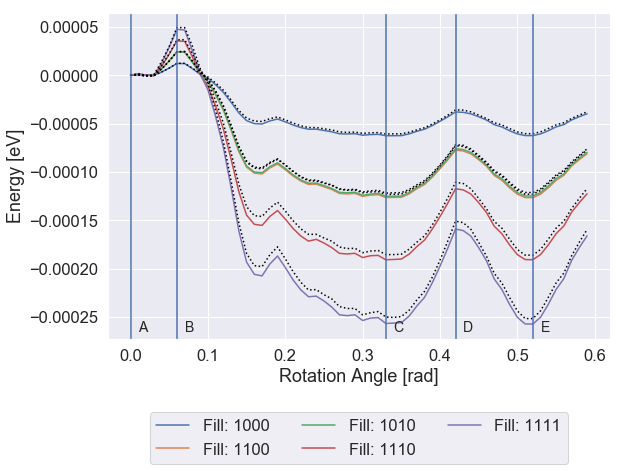

In [8]:
plot_zeroed_comparison()

(<matplotlib.patches.Rectangle at 0x1a222d6eb8>,
  <matplotlib.patches.ConnectionPatch at 0x1a22302a90>])

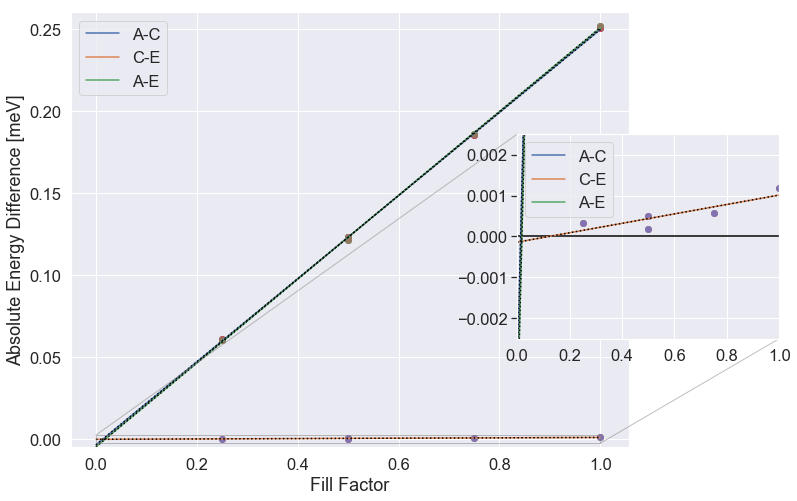

In [16]:
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plot_critical_point_difference(df=raw_df,ax=ax)
plot_critical_point_difference(df=raw_df2,ax=ax,ls=':')
# inset axes....
axins = ax.inset_axes([0.8, 0.25, 0.47, 0.47])
axins.tick_params(left=True, right=False, labelleft=True, labelright=False)
axins.axhline(0,color='black',ls='-')
plot_critical_point_difference(df=raw_df,ax=axins)
plot_critical_point_difference(df=raw_df2,ax=axins,ls=":")
# sub region of the original image
x1, x2, y1, y2 = 0, 1., -0.0025, 0.0025
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.xaxis.label.set_visible(False)
axins.yaxis.label.set_visible(False)

ax.indicate_inset_zoom(axins)


In [10]:
get_critical_energies(1111,raw_df)

([0.0, 0.06, 0.33, 0.42, 0.52],
 [0.0,
  4.746999999838408e-05,
  -0.00025678000000084467,
  -0.00015911999999929094,
  -0.0002573499999982687])